# RBM (Restrictive Boltzmann Machine)

**Energy based model**

> Assigns lower energy values to more relevant features and higher energy values for less important features.

> **Objective**: minimize the energy value.


> **Restrictive**: because the neurons inside the same layer are not connected, but they are fully connected with the neurons in the next layer.

To find the optimal weight W, which minimizes the energy function E, we use **SGD**(Stochastic Gradient Descent). For this we need to compute the derivative of E with respect to v and h (visible and hidden neuron's input), which in turn gives us 2 terms, a positive and negative gradient. 

Positive phase increases the probability of the training data, while the negative decreases it.

To adjust the weights we use the "Contrastive Divergence" algorithm, which build an update matrix that allows to alter incrementally the value of W.
W_new = W + learning_rate * CD

The RBM is trained through several forward and backward passes until it is able to extract the most important features/patterns.
> * **Forward pass**: input processing
> * **Backward pass**: reconstruction


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
class RBM:
  def __init__(self, nv, nh, W=None, hb=None, vb=None):
    """
    nv = nr of neurons in the visible layer
    nh = nr of neurons in the hidden layer
    """
    self.nv = nv
    self.nh = nh

    # initialize the weight matrix
    self.W = W if W else tf.Variable(tf.random.normal([self.nv, self.nh]))
    # bias for hidden layer (initialized with 0)
    self.hb = hb if hb else tf.Variable(np.zeros(self.nh).astype(np.float32))
    # bias for visible layer (initialized with 0)
    self.vb = vb if vb else tf.Variable(np.zeros(self.nv).astype(np.float32))

  def forward_pass(self, v):
    """
     forward pass: compute a sample hidden activation vector (h)
    """
    _h = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hb)
    # compute probability using a relu function
    h = tf.nn.relu(tf.sign(_h - tf.random.uniform(tf.shape(_h))))
    return h

  def backward_pass(self, h):
    """
     backward pass: compute a sample visible activation vector (v)
    """
    _v = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.vb)
    # compute probability using a relu function
    v = tf.nn.relu(tf.sign(_v - tf.random.uniform(tf.shape(_v))))
    return v

  def reconstruct(self, v):
    """
    Represent a forward & backward pass through the network.
    Return the reconstructed image based on the previously learned weights.
    """
    h = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hb)
    return tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.vb)

  def update_cd(self, v0, lr):
    h0 = self.forward_pass(v0)
    v1 = self.backward_pass(h0)
    h1 = self.forward_pass(v1)

    # compute the CD to maximize
    # positive weight gradient
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)
    # negative weight gradient
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)
    # compute the difference between these 2 gradients
    cd = tf.reduce_mean(w_pos_grad - w_neg_grad)

    # update weights using CD
    self.W = self.W + lr * cd
    # update the biases
    self.vb = self.vb + lr * tf.reduce_mean(v0 - v1, 0)
    self.hb = self.hb + lr * tf.reduce_mean(h0 - h1, 0)
    # return the loss
    return self.lms_loss(v0)

  def lms_loss(self, x):
    """
    LMS(Least Mean Squared) error computed based on the original and reconstructed input. 
    """
    # forward pass
    h = self.forward_pass(x)
    # backward pass
    v = self.backward_pass(h)
    loss = tf.math.abs(x - v)
    return tf.reduce_mean(loss * loss)

  def free_energy(self, v):
    """
    Free energy is the energy that a single configuration would need in order to 
    have the same probability as all configurations containing v.
    """
    # transform the visible bias to a column vector
    b = tf.reshape(self.vb, (self.nv, 1))
    visible_term = tf.matmul(v, b)
    # transform the result of the matrix multiplication back to a row vector
    visible_term = tf.reshape(visible_term, (1,-1))

    hidden_term = tf.nn.softplus(tf.matmul(v, self.W) + self.hb)
    hidden_term = tf.reduce_sum(hidden_term, axis=1)

    energy = - visible_term - hidden_term
    return energy

  def compute_energy_loss(self, x):
    # forward pass: initial hidden prob vector based on the input v0
    h = self.forward_pass(x)
    # backward pass: reconstruct the input
    v = self.backward_pass(h)
    # calculate the difference between the energy values of x (visible) and v (hidden vector)
    energy_x = tf.reduce_mean(self.free_energy(x))
    energy_v = tf.reduce_mean(self.free_energy(v))
    loss = tf.math.abs(energy_x - energy_v)
    return loss

  def update(self, x, lr):
    """
    SGD optimizer: used to find the optimal weights which minimize the energy function.
    """
    # gradient descent optimizer used to minimize the energy
    optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    with tf.GradientTape() as tape:
      energy = self.compute_energy_loss(x)
      # energy = self.LMS_loss(x)

    # compute the gradients
    grads = tape.gradient(energy, [self.W, self.hb, self.vb])
    # update the weight and biases
    optimizer.apply_gradients(zip(grads, [self.W, self.hb, self.vb]))

    return energy

  def cross_entropy_loss(self, x):
    # forward pass
    h = self.forward_pass(x)
    # backward pass
    v = self.backward_pass(h)
    # calculate the cross-entropy loss
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=v))
    return loss

  def train(self, x, lr=0.001, batch_size=64, epochs=15):
      nr_inputs = x.shape[0]
      train_losses = []

      for epoch in range(0, epochs):
        epoch_loss = 0
        s = 0
        for i in range(0, nr_inputs - batch_size, batch_size):
          # extract the next batch of data (input to the visible nodes)
          v0 = x[i:i+batch_size].reshape(batch_size, -1)
          # update the weight matrix and the visible bias & hidden bias
          loss = self.update(v0, lr)
          # self.update_cd(v0, lr=lr)
          # loss = self.lms_loss(v0)
          epoch_loss += loss
          s+=1
          train_losses.append(loss)

        print('Epoch: ', epoch, ', train loss:', end=" ")
        tf.print(epoch_loss/s)

      self.plot_loss(train_losses)

      return np.asarray(train_losses).mean()

  def test(self, x, batch_size=64):
      nr_inputs = x.shape[0]
      test_losses = []

      for i in range(0, nr_inputs - batch_size, batch_size):
          # extract the next batch of data (input to the visible nodes)
          v0 = x[i:i+batch_size].reshape(batch_size, -1)
          # calculate the loss
          loss = self.compute_energy_loss(v0)
          # loss = self.lms_loss(v0)
          test_losses.append(loss)

      self.plot_loss(test_losses)

      return np.asarray(test_losses).mean()

  def plot_loss(self, loss):
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss)
    plt.show()

In [3]:
import tensorflow_datasets as tfds

# load and prepare the input dataset
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

(lost_and_found_train_ds, lost_and_found_test_ds), lost_and_found_info = tfds.load(
    'lost_and_found/semantic_segmentation',
    split=['train[:75%]','train[75%:]'],
    with_info=True)

lost_and_found_train_df = tfds.as_dataframe(lost_and_found_train_ds.take(10), lost_and_found_info)
x_train_img = lost_and_found_train_df['image_left'].to_numpy()
x_train_mask = lost_and_found_train_df['segmentation_label'].to_numpy()
print("Train img: ", x_train_img[0].shape)
print("Train mask: ", x_train_mask[0].shape)

lost_and_found_test_df = tfds.as_dataframe(lost_and_found_test_ds.take(5), lost_and_found_info)
x_test_img = lost_and_found_test_df['image_left'].to_numpy()
x_test_mask = lost_and_found_test_df['segmentation_label'].to_numpy()
print("Test img: ", x_test_img[0].shape)
print("Test mask: ", x_test_mask[0].shape)

Train img:  (1024, 2048, 3)
Train mask:  (1024, 2048, 1)
Test img:  (1024, 2048, 3)
Test mask:  (1024, 2048, 1)


In [15]:
import cv2

def extract_patch(img, bw, bh):
  """
  Find a patch with uniform road surface.
  Use sliding window approach with a predefined region size and compare the regions based on min std deviation.
  bw = bbox width
  bh = bbox height
  """
  height, width = img.shape
  bx = 0
  by = 0
  min_std_dev = 255
  threshold = 100
  for y in range(height//2, height-bh, bh):
    for x in range(0, width-bw, bw):
      mean, std_dev = cv2.meanStdDev(img[y:(y+bh),x:(x+bw)])
      if mean > threshold and std_dev < min_std_dev:
        min_std_dev = std_dev
        bx = x
        by = y
  # print("Min std dev: ", min_std_dev)

  return by, by+bh, bx, bx+bw

def apply_mask(img, mask, road_color):
  # create a binary mask for selecting only the road surface
  road_mask = np.apply_along_axis(lambda p: 0 if p != road_color else p, 2, mask)
  # extract only the road surface from the image
  result = np.multiply(img, road_mask)

  return result

def convert_to_grayscale(img):
  img = img.astype('uint8')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

def extract_region(x, y, patch_size):
  data = []
  for img, mask in zip(x,y):
    if img.ndim == 3:
      # convert color images to grayscale
      img = convert_to_grayscale(img)
    # map the mask on the image to indicate the road surface
    img = apply_mask(img, mask, 1)
    (bw, bh) = patch_size
    h1, h2, w1, w2 = extract_patch(img, bw, bh)
    cropped_image = img[h1:h2, w1:w2]
    data.append(cropped_image)

  return np.asarray(data)

def preprocess_input(x, y, patch_size):
  x = extract_region(x, y, patch_size)
  # shuffle the data
  x = np.random.permutation(x)
  # normalize input values
  x = x / 255.0
  x = x.astype(np.float32)
  return x

(10, 200, 200)


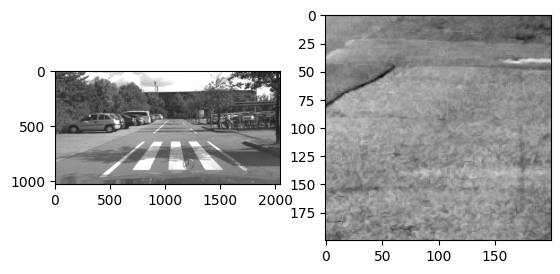

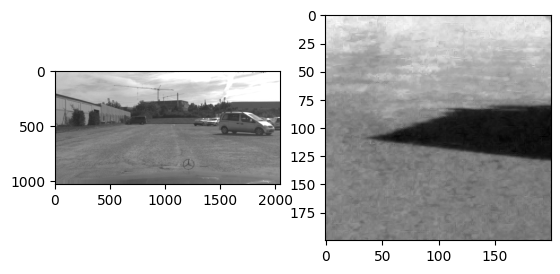

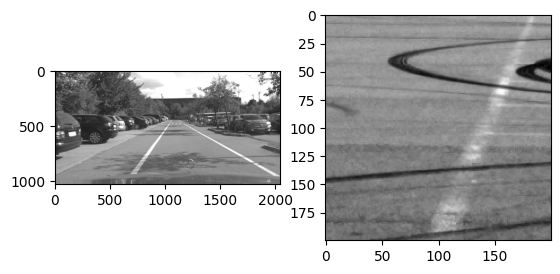

In [16]:
region_size = (200,200)
X_train = preprocess_input(x_train_img, x_train_mask, region_size)
X_test = preprocess_input(x_test_img, x_test_mask, region_size)

print(X_train.shape)

s = 3
for i in range(s):
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(convert_to_grayscale(x_train_img[i]), cmap='gray')
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(X_train[i], cmap='gray')

In [18]:
nv = X_train.shape[1] * X_train.shape[2]
nh = 100
rbm = RBM(nv, nh)

Epoch:  0 , train loss: 108951.719
Epoch:  1 , train loss: 103944.906
Epoch:  2 , train loss: 99807.4062
Epoch:  3 , train loss: 96705.1406
Epoch:  4 , train loss: 92950.9062
Epoch:  5 , train loss: 89602.2656
Epoch:  6 , train loss: 86783.1
Epoch:  7 , train loss: 83601.4922
Epoch:  8 , train loss: 80592.6797
Epoch:  9 , train loss: 77292.4
Epoch:  10 , train loss: 74611.4609
Epoch:  11 , train loss: 71278.7891
Epoch:  12 , train loss: 68273.6172
Epoch:  13 , train loss: 65506.1797
Epoch:  14 , train loss: 62562.75
Epoch:  15 , train loss: 59854.8594
Epoch:  16 , train loss: 57302.8672
Epoch:  17 , train loss: 54373.6211
Epoch:  18 , train loss: 51787.1914
Epoch:  19 , train loss: 49089.7


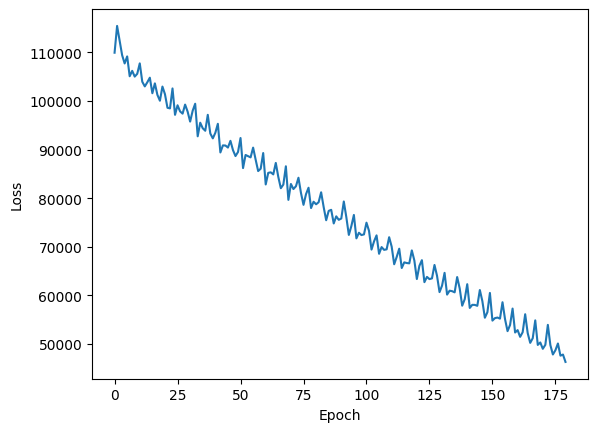

Train Error:  76743.66


In [19]:
# train the model
train_error = rbm.train(X_train, lr=0.001, batch_size=1, epochs=20)
print("Train Error: ", train_error)

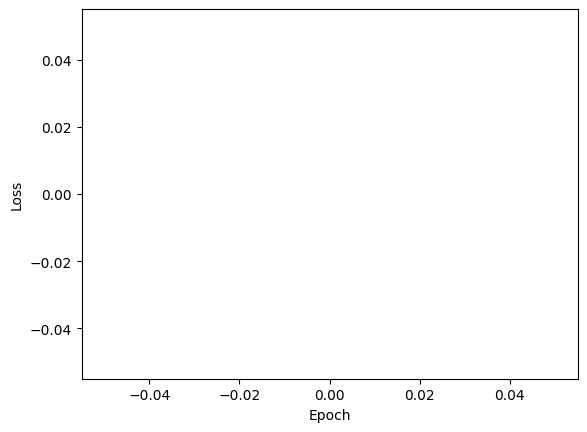

Test Error:  nan


C:\Users\keresztesbea\AppData\Local\Temp\ipykernel_8704\1786934013.py:170: RuntimeWarning: Mean of empty slice.
  return np.asarray(test_losses).mean()
D:\university\computer_vision\python_interpreter\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
# test the model on the test set
test_error = rbm.test(X_test)
print("Test Error: ", test_error)

In [67]:
def fill_road_texture(mask, background_color, texture):
  height, width, _ = mask.shape
  result = np.zeros((height, width))
  bh, bw = texture.shape
  for y in range(0, height-bh, bh):
    for x in range(0, width-bw, bw):
      result[y:(y+bh),x:(x+bw)] = texture * 255
  for y in range(0, height):
    for x in range(0, width):
      if mask[y][x] == background_color:
        result[y][x] = 0

  return result

In [68]:
# verify the model on a few sample data from the test set
nr_samples = x_test_mask.shape[0]
# generate nr_samples random indices to select a sample subset from the test set
rand_indices = np.random.choice(X_test.shape[0], nr_samples, replace=False)
rand_samples = X_test[rand_indices]
# flatten the image data (matrix of pixels) to a 1D array (feature vector)
flattened_samples = rand_samples.reshape(nr_samples, -1)
# reconstruct the images
reconstructed_samples = rbm.reconstruct(flattened_samples)
# convert the 1D outputs to the original 2D image shape
reconstructed_samples = reconstructed_samples.numpy().reshape(rand_samples.shape)

In [69]:
def show_image_pairs(a, b, n):
  for i in range(0,n):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(a[i], cmap='gray')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(b[i], cmap='gray')

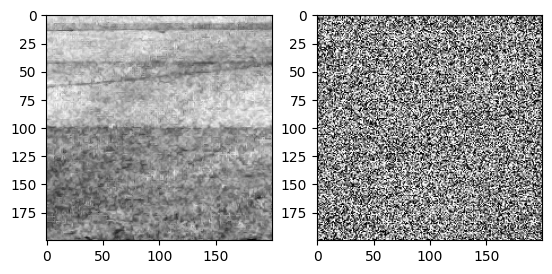

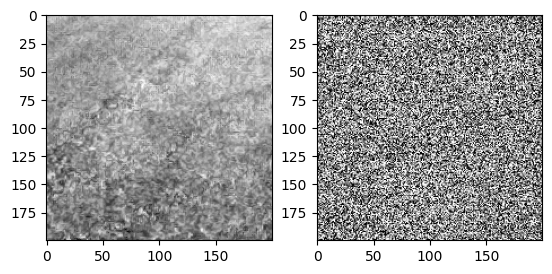

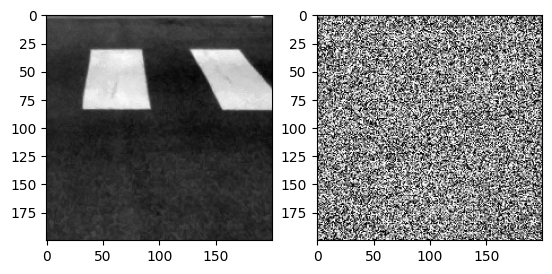

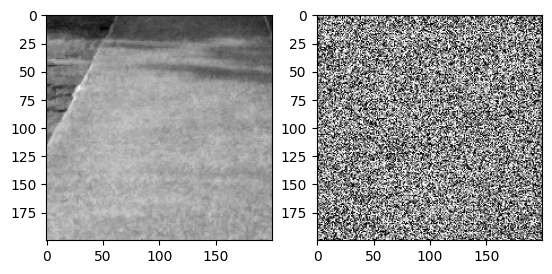

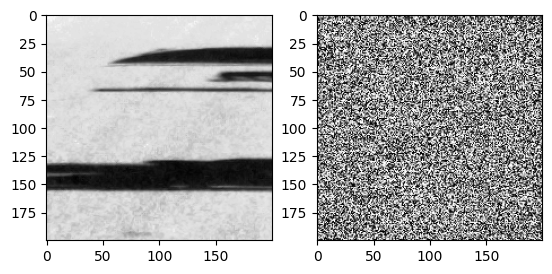

In [70]:
# display the samples and the reconstructed patches
show_image_pairs(rand_samples, reconstructed_samples, nr_samples)

In [66]:
from PIL import Image

def save_img(img_arr, file_name):
  # img_arr = img_arr * 255
  img_arr = img_arr.astype(np.uint8)
  img = Image.fromarray(img_arr)
  img.save(file_name)

In [71]:
for i in range(nr_samples):
  gray = convert_to_grayscale(x_test_img[i])
  img = cv2.merge([gray, gray, gray])
  save_img(img, "output/original/test{}.jpeg".format(i))

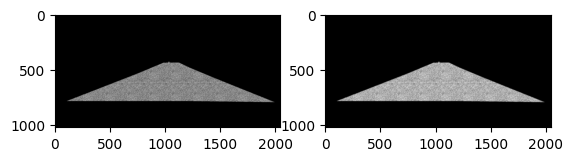

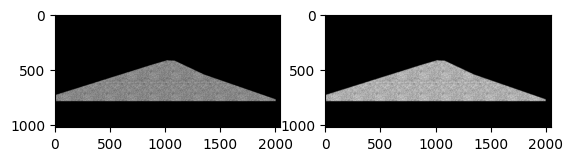

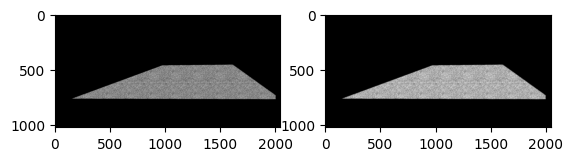

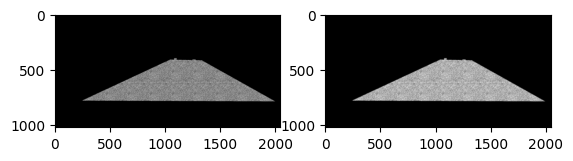

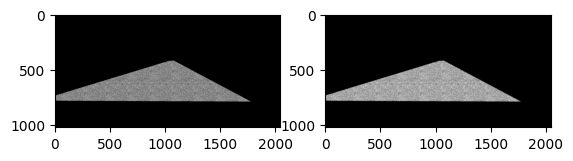

In [72]:
# map the texture to the original road mask
results = []
smooth_results = []
i=0
for mask, reconstructed_sample in zip(x_test_mask, reconstructed_samples):
  reconstructed_road = fill_road_texture(mask, 0, reconstructed_sample)
  results.append(reconstructed_road)
  # save_img(reconstructed_road, "output/raw/test{}.jpeg".format(i))
  # apply gaussian blur to eliminate the noise and smooth the surface texture
  blurred_img = cv2.GaussianBlur(reconstructed_road, (7,7), 0)
  smooth_results.append(blurred_img)
  save_img(blurred_img, "output/smooth/test{}.jpeg".format(i))
  i += 1

show_image_pairs(results, smooth_results, i)

Compare the original image with the reconstructed one to identify objects on the road surface. Generate a heatmap (binary mask) using a predefined threshold to filter out noises.

In [129]:
def generate_heatmap(img, reconstructed, threshold):
  height,width,_ = img.shape
  heatmap = np.ones((height,width))
  heatmap *= 255
  gray_img = convert_to_grayscale(img)
  for y in range(height):
    for x in range(width):
      difference = np.abs(gray_img[y][x] - reconstructed[y][x])
      if reconstructed[y][x] > 0 and difference > threshold:
        heatmap[y][x] = 0

  # apply dilation
  kernel = np.ones((5, 5), np.uint8)
  heatmap = cv2.erode(heatmap, kernel, iterations=3)

  return heatmap

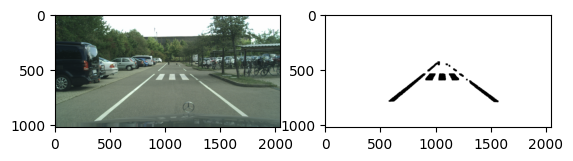

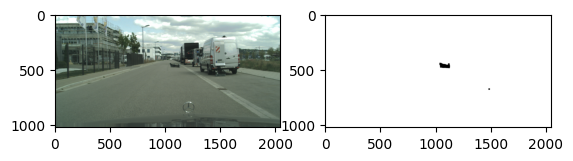

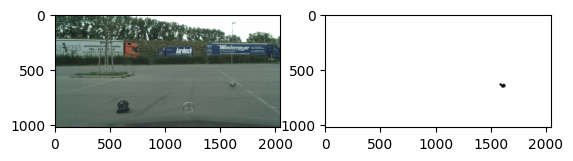

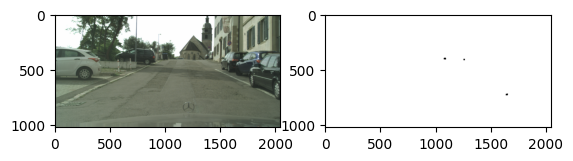

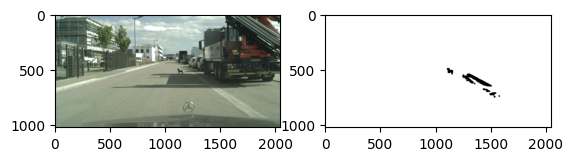

In [130]:
heatmaps = []
T = 190

i = 0
for img, reconstructed in zip(x_test_img, results):
  heatmap = generate_heatmap(img, reconstructed, T)
  heatmaps.append(heatmap)
  save_img(heatmap, "output/heatmap/test{}.jpeg".format(i))
  i += 1
  # break

show_image_pairs(x_test_img, heatmaps, i)


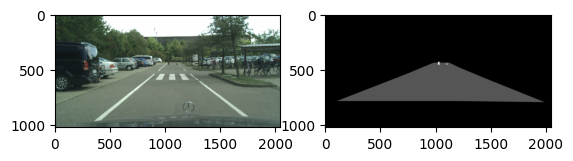

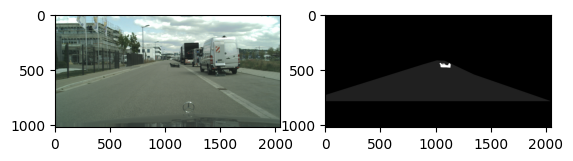

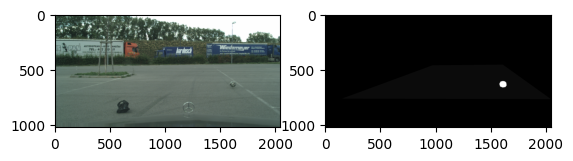

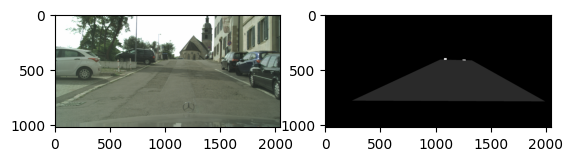

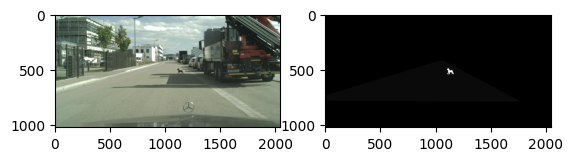

In [88]:
show_image_pairs(x_test_img, x_test_mask, 5)